In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

inspire by this part to use the optimized preconditioning and loss weighting terms
https://github.com/yuanzhi-zhu/mini_edm/blob/9031fda7ff9f3887581a93c9a4024e67e819537e/train_edm.py#L57
we will skip the ema part for now, focusing on preconditioning and loss weight sampling. 


In [6]:

# EDM loss
# https://github.com/NVlabs/edm/blob/008a4e5316c8e3bfe61a62f874bddba254295afb/training/loss.py#L66
class EDMLoss:
    def __init__(self, P_mean=-1.2, P_std=1.2, sigma_data=0.5):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, X, labels=None, ):
        rnd_normal = torch.randn([X.shape[0],] + [1, ] * (X.ndim - 1), device=X.device)
        # unsqueeze to match the ndim of X
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        # maybe augment
        n = torch.randn_like(X) * sigma
        D_yn = net(X + n, sigma, cond=labels, )
        loss = weight * ((D_yn - X) ** 2)
        return loss

In [28]:
class EDMPrecondWrapper(nn.Module):
    def __init__(self, model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0):
        super().__init__()
        self.model = model
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        
    def forward(self, X, sigma, cond=None, ):
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        # unsqueze sigma to have same dimension as X (which may have 2-4 dim) 
        sigma_vec = sigma.view([-1, ] + [1, ] * (X.ndim - 1))
        c_skip = self.sigma_data ** 2 / (sigma_vec ** 2 + self.sigma_data ** 2)
        c_out = sigma_vec * self.sigma_data / (sigma_vec ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma_vec ** 2).sqrt()
        c_noise = sigma.log() / 4
        model_out = self.model(c_in * X, c_noise, cond=cond)
        return c_skip * X + c_out * model_out
    
    

In [29]:
import sys
sys.path.append("..")
from core.diffusion_nn_lib import UNetMLPBlock, GaussianFourierProjection

class UNetBlockStyleMLP_backbone(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, ndim=2, nlayers=5, nhidden=64, time_embed_dim=64,):
    super().__init__()
    self.embed = GaussianFourierProjection(time_embed_dim, scale=1)
    layers = nn.ModuleList()
    layers.append(UNetMLPBlock(ndim, nhidden, time_embed_dim))
    for _ in range(nlayers-2):
        layers.append(UNetMLPBlock(nhidden, nhidden, time_embed_dim))
    layers.append(nn.Linear(nhidden, ndim))
    self.net = layers

  def forward(self, x, t_enc, cond=None):
    # t_enc : preconditioned version of sigma, usually 
    # ln_std_vec = torch.log(std_vec) / 4
    t_embed = self.embed(t_enc)
    for layer in self.net[:-1]:
        x = layer(x, t_embed)
    pred = self.net[-1](x)
    return pred


In [92]:
from torch.optim import Adam
from tqdm.auto import trange, tqdm

def train_score_model_custom_loss(X_train_tsr, score_model_td, loss_fn,
                   lr=0.005,
                   nepochs=750,
                   batch_size=None,
                   device="cpu"):
    ndim = X_train_tsr.shape[1]
    score_model_td.to(device)
    X_train_tsr = X_train_tsr.to(device)
    optim = Adam(score_model_td.parameters(), lr=lr)
    pbar = trange(nepochs)
    score_model_td.train()
    loss_traj = []
    for ep in pbar:
        if batch_size is None:
            loss = loss_fn(score_model_td, X_train_tsr, )
        else:
            idx = torch.randint(0, X_train_tsr.shape[0], (batch_size,))
            loss = loss_fn(score_model_td, X_train_tsr[idx], )
        loss = loss.mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        pbar.set_description(f"step {ep} loss {loss.item():.3f}")
        if ep == 0:
            print(f"step {ep} loss {loss.item():.3f}")
        loss_traj.append(loss.item())
    
    return score_model_td, loss_traj

In [89]:

import numpy as np
def generate_spiral_samples_torch(n_points, a=1, b=0.2):
    """Generate points along a spiral using PyTorch.
    Parameters:
    - n_points (int): Number of points to generate.
    - a, b (float): Parameters that define the spiral shape.
    Returns:
    - torch.Tensor: Batch of vectors representing points on the spiral.
    """
    theta = torch.linspace(0, 4 * np.pi, n_points)  # angle theta
    r = a + b * theta  # radius
    x = r * torch.cos(theta)  # x = r * cos(theta)
    y = r * torch.sin(theta)  # y = r * sin(theta)
    spiral_batch = torch.stack((x, y), dim=1)
    return spiral_batch


def generate_ring_samples_torch(n_points, R=1, ):
    """
    Generate points along a Ring using PyTorch.
    Parameters:
    - n_points (int): Number of points to generate.
    - R: Radius of the ring.
    Returns:
    - torch.Tensor: Batch of vectors representing points on the spiral.
    """
    theta = torch.linspace(0, 2 * np.pi, n_points + 1, )  # angle theta
    theta = theta[:-1]
    x = R * torch.cos(theta)  # x = r * cos(theta)
    y = R * torch.sin(theta)  # y = r * sin(theta)
    spiral_batch = torch.stack((x, y), dim=1)
    return spiral_batch


def random_radius_function(angles, amplitudes, phases, R0=1):
    num_modes = len(amplitudes)
    freqs = np.arange(1, num_modes+1)
    radii = R0 + np.sum(amplitudes[None, :] * np.cos(freqs[None, :] * angles[:,None] + phases[None, :]), axis=1)
    return radii


def create_random_star_shape(num_points, num_modes):
    amplitudes = 0.4 * np.random.rand(num_modes) - 0.2
    phases = 2 * np.pi * np.random.rand(num_modes)
    angles = np.linspace(0, 2*np.pi, num_points)
    radii = random_radius_function(angles, amplitudes, phases)
    radius_fun = lambda angles: random_radius_function(angles, amplitudes, phases)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    pnts = np.vstack((x, y)).T
    return pnts, radius_fun, amplitudes, phases


def generate_random_star_shape_torch(num_points, num_modes=10):
    pnts, radius_fun, amplitudes, phases = create_random_star_shape(num_points, num_modes)
    return torch.from_numpy(pnts), radius_fun, amplitudes, phases

In [37]:
pnts = generate_spiral_samples_torch(1000)
pnts.std(dim=0)

tensor([1.6811, 1.6612])

In [38]:
device = "mps"
model = UNetBlockStyleMLP_backbone(ndim=2, nlayers=5, nhidden=64, time_embed_dim=64,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)

In [39]:
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                        lr=0.001, nepochs=2000, batch_size=1024, device="mps")

step 6 loss 3.046:   0%|          | 4/2000 [00:02<14:43,  2.26it/s]  

step 0 loss 6.506


step 1999 loss 1.851: 100%|██████████| 2000/2000 [01:06<00:00, 30.23it/s]


In [63]:
@torch.no_grad()
def edm_sampler(
    edm, latents, class_labels=None,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7, 
    dtype=torch.float32, return_traj=False,
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, edm.sigma_min)
    sigma_max = min(sigma_max, edm.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=dtype, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    # t_steps = torch.cat([edm.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0
    
    x_traj = []
    denoiser_traj = []
    # Main sampling loop.
    x_next = latents.to(dtype) * t_steps[0]
    x_traj.append(x_next)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_hat = x_next
        t_hat = t_cur
        
        # Euler step.
        denoised = edm(x_hat, t_hat, class_labels, ).to(dtype)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = edm(x_next, t_next, class_labels, ).to(dtype)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        x_traj.append(x_next)
        denoiser_traj.append(denoised)
    if return_traj:
        x_traj = torch.stack(x_traj, dim=0)
        denoiser_traj = torch.stack(denoiser_traj, dim=0)
        return x_next, x_traj, denoiser_traj, t_steps
    else:
        return x_next

In [81]:
noise_init = torch.randn(1000, 2).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                    num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

In [82]:
scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaling

tensor([0.0125, 0.0144, 0.0166, 0.0193, 0.0224, 0.0261, 0.0306, 0.0359, 0.0423,
        0.0501, 0.0595, 0.0710, 0.0850, 0.1023, 0.1236, 0.1500, 0.1827, 0.2233,
        0.2733, 0.3344, 0.4076, 0.4925, 0.5861, 0.6822, 0.7722, 0.8478, 0.9050,
        0.9442, 0.9688, 0.9834, 0.9915, 0.9958, 0.9980, 0.9991, 0.9996, 0.9998,
        0.9999, 1.0000, 1.0000, 1.0000, 1.0000], device='mps:0')

In [57]:
import matplotlib.pyplot as plt

(-4.448216187953949, 4.390164840221405, -3.9376464247703553, 3.664980208873749)

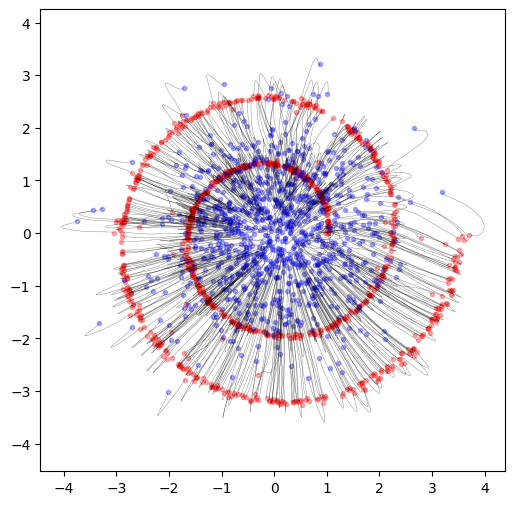

In [88]:
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[6,6])
plt.plot(scaled_x_traj[:, :, 0].numpy(), 
         scaled_x_traj[:, :, 1].numpy(), lw=0.3, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=9, marker='o', alpha=0.3)
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3)
plt.axis("equal")

(-3.4604708194732665, 4.067791604995728, -3.642213225364685, 2.906427264213562)

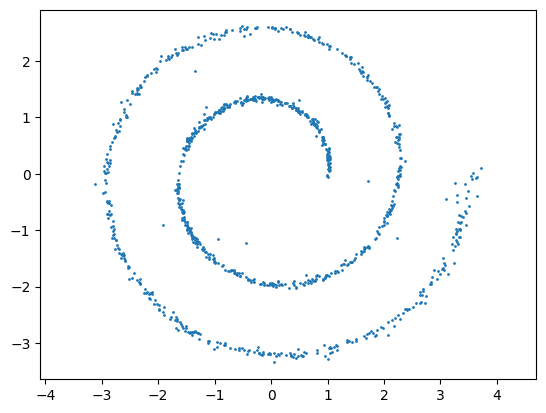

In [53]:
plt.scatter(x_out[:, 0].cpu().numpy(), x_out[:, 1].cpu().numpy(), s=1)
plt.axis("equal")

In [95]:
pnts, radii_fun, ampls, phases = generate_random_star_shape_torch(2000)
pnts.std(dim=0)
pnts = pnts.float()

In [96]:
device = "mps"
model = UNetBlockStyleMLP_backbone(ndim=2, nlayers=5, nhidden=64, time_embed_dim=64,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                        lr=0.001, nepochs=2000, batch_size=1024, device="mps")

  0%|          | 0/2000 [00:00<?, ?it/s]

step 0 loss 2.015


In [105]:
noise_init = torch.randn(1000, 2).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                    num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

In [106]:
scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaling

tensor([0.0125, 0.0144, 0.0166, 0.0193, 0.0224, 0.0261, 0.0306, 0.0359, 0.0423,
        0.0501, 0.0595, 0.0710, 0.0850, 0.1023, 0.1236, 0.1500, 0.1827, 0.2233,
        0.2733, 0.3344, 0.4076, 0.4925, 0.5861, 0.6822, 0.7722, 0.8478, 0.9050,
        0.9442, 0.9688, 0.9834, 0.9915, 0.9958, 0.9980, 0.9991, 0.9996, 0.9998,
        0.9999, 1.0000, 1.0000, 1.0000, 1.0000], device='mps:0')

In [107]:
import matplotlib.pyplot as plt

(-3.2150653481483458, 3.580624210834503, -3.385376441478729, 3.753955590724945)

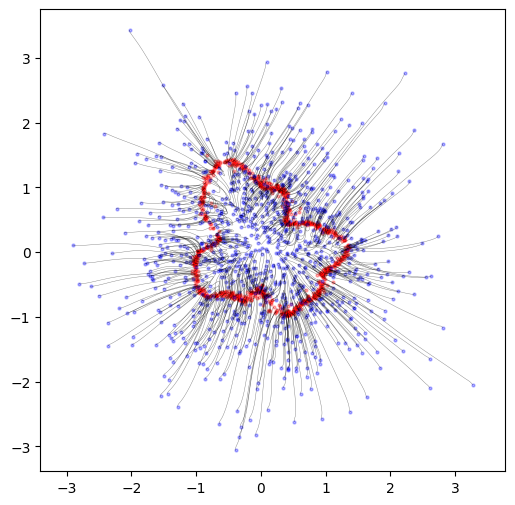

In [108]:
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[6,6])
plt.plot(scaled_x_traj[:, :, 0].numpy(), 
         scaled_x_traj[:, :, 1].numpy(), lw=0.3, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3)
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=4, marker='o', alpha=0.3)
plt.axis("equal")

step 6 loss 3.046:   0%|          | 4/2000 [00:02<14:43,  2.26it/s]  

step 0 loss 6.506


step 1999 loss 1.851: 100%|██████████| 2000/2000 [01:06<00:00, 30.23it/s]


In [ ]:
# Preconditioning method in EDM1
# https://github.com/NVlabs/edm/blob/008a4e5316c8e3bfe61a62f874bddba254295afb/training/networks.py#L632
class EDMPreconditioning:
    def __init__(self, model=None, cfg=None):
        self.cfg = cfg
        self.device = self.cfg.device
        self.model = model.to(self.device)
        self.ema = copy.deepcopy(self.model).eval().requires_grad_(False)
        ## parameters
        self.sigma_min = cfg.sigma_min
        self.sigma_max = cfg.sigma_max
        self.rho = cfg.rho
        self.sigma_data = cfg.sigma_data
        self.P_mean = -1.2
        self.P_std = 1.2
        self.sigma_data = 0.5
        # self.ema_rampup_ratio = 0.05
        # self.ema_halflife_kimg = 500

    def model_forward_wrapper(self, x, sigma, use_ema=False, **kwargs):
        """Wrapper for the model call"""
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        label = kwargs['labels'] if 'labels' in kwargs else None
        if use_ema:
            model_output = self.ema(torch.einsum('b,bijk->bijk', c_in, x), c_noise, class_labels=label)
        else:
            model_output = self.model(torch.einsum('b,bijk->bijk', c_in, x), c_noise, class_labels=label)
        try:
            model_output = model_output.sample
        except:
            pass
        return torch.einsum('b,bijk->bijk', c_skip, x) + torch.einsum('b,bijk->bijk', c_out, model_output)
    

In [ ]:
# Network preconditioning. 

In [ ]:

class VELoss_full:
    def __init__(self, sigma_min=0.02, sigma_max=100):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max

    def __call__(self, net, images, labels, augment_pipe=None):
        rnd_uniform = torch.rand([images.shape[0], 1, 1, 1], device=images.device)
        sigma = self.sigma_min * ((self.sigma_max / self.sigma_min) ** rnd_uniform)
        weight = 1 / sigma ** 2
        y, augment_labels = augment_pipe(images) if augment_pipe is not None else (images, None)
        n = torch.randn_like(y) * sigma
        D_yn = net(y + n, sigma, labels, augment_labels=augment_labels)
        loss = weight * ((D_yn - y) ** 2)
        return loss


class VPLoss_full:
    def __init__(self, beta_d=19.9, beta_min=0.1, epsilon_t=1e-5):
        self.beta_d = beta_d
        self.beta_min = beta_min
        self.epsilon_t = epsilon_t

    def __call__(self, net, images, labels, augment_pipe=None):
        rnd_uniform = torch.rand([images.shape[0], 1, 1, 1], device=images.device)
        sigma = self.sigma(1 + rnd_uniform * (self.epsilon_t - 1))
        weight = 1 / sigma ** 2
        y, augment_labels = augment_pipe(images) if augment_pipe is not None else (images, None)
        n = torch.randn_like(y) * sigma
        D_yn = net(y + n, sigma, labels, augment_labels=augment_labels)
        loss = weight * ((D_yn - y) ** 2)
        return loss

    def sigma(self, t):
        t = torch.as_tensor(t)
        return ((0.5 * self.beta_d * (t ** 2) + self.beta_min * t).exp() - 1).sqrt()


class EDMLoss_full:
    def __init__(self, P_mean=-1.2, P_std=1.2, sigma_data=0.5):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, images, labels=None, augment_pipe=None):
        # sampling frequency of sigma 
        rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        # weighting of loss of each sigma
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        y, augment_labels = augment_pipe(images) if augment_pipe is not None else (images, None)
        n = torch.randn_like(y) * sigma
        D_yn = net(y + n, sigma, labels, augment_labels=augment_labels)
        loss = weight * ((D_yn - y) ** 2)
        return loss
    

In [ ]:
# https://github.com/NVlabs/edm2/blob/38d5a70fe338edc8b3aac4da8a0cefbc4a057fb8/training/training_loop.py#L28
